In [1]:
EPOCHS = 500
INLEN = 32
HIDDEN = 64
LSTMLAYERS = 2
ATTHEADS = 1
DROPOUT = 0.1
BATCH = 32

N_FC = 36           # default forecast horizon
RAND = 42           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

TRAIN = "19571201"  # train/test split
MSEAS = 60          # max seasonality to check: months
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
data_ins = pd.read_csv('data_inside.csv')
data_outs = pd.read_csv('data_outside.csv')

# combine inside and outside data and interpolate based on time of inside
data = pd.merge(data_ins, data_outs, on='time', how='outer')
# Converting the index to DatetimeIndex
data.index = pd.to_datetime(data['time'])
data_interp = data.interpolate(method='time')
# Get Out NaNs
data_interp = data_interp.dropna()

In [3]:
data_interp

,time,temperature_x,humidity_x,pressure_x,current,voltage,temperature_y,humidity_y,pressure_y,Live_Irms,Irms
time,,,,,,,,,,,
2023-04-23 23:28:47.033312,2023-04-23 23:28:47.033312,17.25,54.50,"99,514.83","65,401.45","18,501.12",20.26,44.90,"99,531.02",2.97,2.46
2023-04-23 23:28:57.568134,2023-04-23 23:28:57.568134,17.25,54.50,"99,514.83","65,401.45","18,501.12",20.27,44.89,"99,530.90",3.00,2.51
2023-04-23 23:29:08.103129,2023-04-23 23:29:08.103129,17.25,54.50,"99,514.83","65,401.45","18,501.12",20.27,44.90,"99,530.56",2.89,2.57
2023-04-23 23:29:18.656842,2023-04-23 23:29:18.656842,17.25,54.50,"99,514.83","65,401.45","18,501.12",20.26,44.89,"99,531.23",2.96,2.65
2023-04-23 23:29:29.195516,2023-04-23 23:29:29.195516,17.25,54.50,"99,514.87","65,401.45","18,501.12",20.28,44.91,"99,531.68",10.19,221.51
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 11:39:59.224155,2023-04-24 11:39:59.224155,4.57,41.05,"100,285.19","65,401.45","18,501.12",19.78,41.65,"100,306.41",2.96,2.58
2023-04-24 11:40:09.771412,2023-04-24 11:40:09.771412,4.57,41.11,"100,285.44","65,401.45","18,501.12",19.80,41.64,"100,302.28",3.03,2.80
2023-04-24 11:40:20.318304,2023-04-24 11:40:20.318304,4.57,41.11,"100,285.44","65,401.45","18,501.12",19.81,41.62,"100,299.92",2.95,2.51


In [6]:
# create a TimeSeries object from the dataframe
# resample the data to a 10-second frequency
df_resampled = data_interp.resample('10S').mean()
# Drop NaN values by interpolating
df_resampled = data_interp.interpolate(method='time')
df_resampled = data_interp.resample('10S').mean()
# Drop NaN values
df_resampled = df_resampled.dropna()
# print the TimeSeries object
# print(series)
df_resampled['temperature_x']

time
2023-04-23 23:28:40   17.25
2023-04-23 23:28:50   17.25
2023-04-23 23:29:00   17.25
2023-04-23 23:29:10   17.25
2023-04-23 23:29:20   17.25
                       ... 
2023-04-24 11:39:50    4.57
2023-04-24 11:40:00    4.57
2023-04-24 11:40:20    4.57
2023-04-24 11:40:30    4.57
2023-04-24 11:40:40    4.57
Name: temperature_x, Length: 4167, dtype: float64

In [7]:
ts = TimeSeries.from_series(df_resampled['temperature_x'], fill_missing_dates=True, freq='10S')

In [8]:
ts

<TimeSeries (DataArray) (time: 4393, component: 1, sample: 1)>
array([[[17.25]],

       [[17.25]],

       [[17.25]],

       ...,

       [[ 4.57]],

       [[ 4.57]],

       [[ 4.57]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-23T23:28:40 ... 2023-04-24T11:40:40
  * component  (component) object 'temperature_x'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

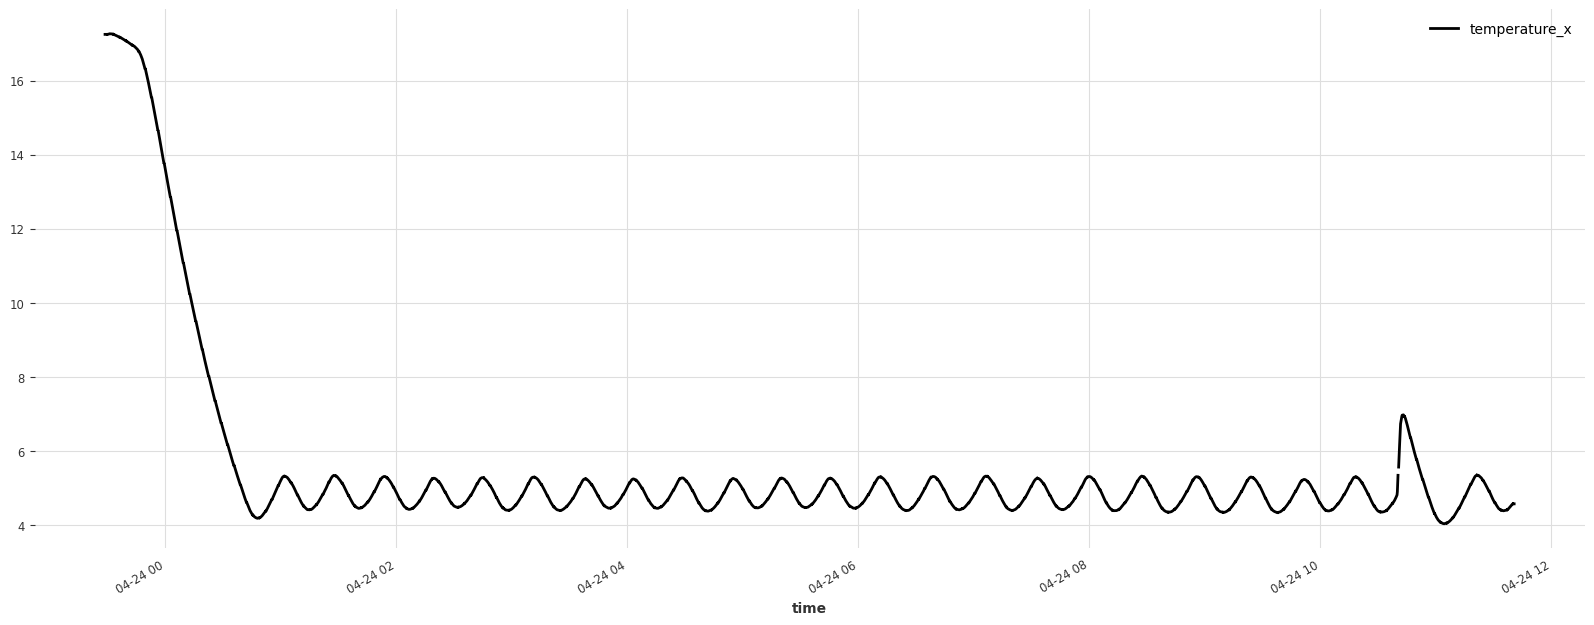

In [9]:
plt.figure(100, figsize=(20, 7))
ts.plot()

#### Check seasonality
- Kijk hoeveel "Seizoenen" er zijn
- In dit geval niet maanden maar periodes van koelen en verwarmen

In [10]:
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
# check for seasonality, via ACF
MSEAS = 100
mseas=MSEAS
ALPHA = 0.5
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of {} times'.format(mseas))

seasonal? False


In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [12]:
TRAIN = "19571201"  # train/test split
TRAIN = "2023-04-24 8:40:00"
# train/test
if isinstance(TRAIN, str):
    split = pd.Timestamp(TRAIN)
else:
    split = TRAIN
ts_train, ts_test = ts.split_after(split)

# scale the time series on the training settransformer = Scaler()
transformer = Scaler()
ts_ttrain = transformer.fit_transform(ts_train)
ts_ttest = transformer.transform(ts_test)
ts_t = transformer.transform(ts)
tcov = ts_t

In [15]:
EPOCHS = 10
INLEN = 32
HIDDEN = 32
LSTMLAYERS = 2
ATTHEADS = 1
DROPOUT = 0.1
BATCH = 32

N_FC = 36           # default forecast horizon
RAND = 42           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

model = TFTModel(   input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTHEADS,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    random_state=RAND, 
                    force_reset=True)
                    
                    
model.fit(  ts_ttrain, 
            future_covariates=tcov, 
            verbose=True)    

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=32, lstm_layers=2, num_attention_heads=1, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x000001FE147F0550>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=32, output_chunk_length=36, batch_size=32, n_epochs=10, random_state=42, force_reset=True)

In [59]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_test), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS)
                            
print("Do the predictions constitute a probabilistic time series?", ts_tpred.is_probabilistic)                       
               

Predicting: 0it [00:00, ?it/s]

Do the predictions constitute a probabilistic time series? True


<TimeSeries (DataArray) (time: 1084, component: 1, sample: 100)>
array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-24T08:40:10 ... 2023-04-24T11:40:40
  * component  (component) object 'temperature_x'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

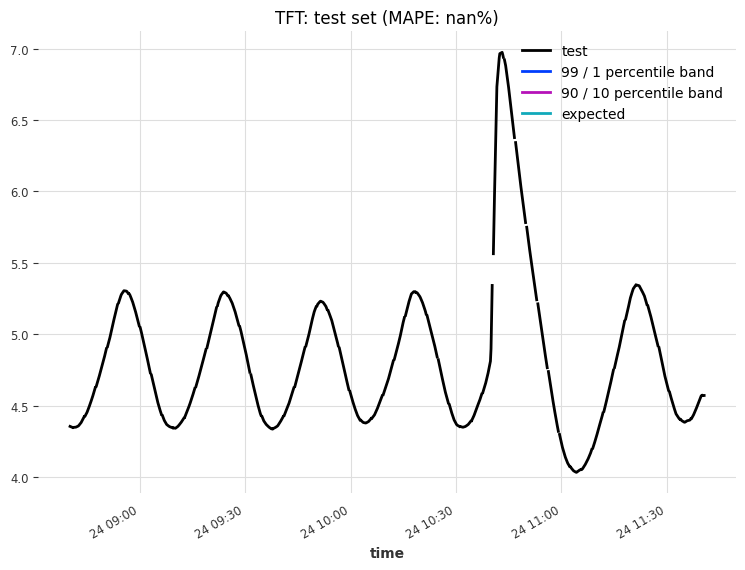

In [68]:
# testing: helper function: plot predictions
def plot_predict(ts_actual, ts_test, ts_pred):
    
    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)
    
    # ts_actual.plot(label="actual")     
    ts_test.plot(label='test')                                   # plot test
    
    ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
    plt.title("TFT: test set (MAPE: {:.2f}%)".format(mape(ts_test, ts_pred)))
    plt.legend();  
    
    
    
 # testing: call helper function: plot predictions
ts_pred = transformer.inverse_transform(ts_tpred)
plot_predict(series, ts_test, ts_pred)
ts_tpred

In [16]:
ts_train

<TimeSeries (DataArray) (time: 3309, component: 1, sample: 1)>
array([[[17.25]],

       [[17.25]],

       [[17.25]],

       ...,

       [[ 4.37]],

       [[ 4.36]],

       [[ 4.36]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-23T23:28:40 ... 2023-04-24T08:40:00
  * component  (component) object 'temperature_x'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [21]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import SeasonalityMode

tss_training, tss_validation = ts_train.split_after(pd.Timestamp('2023-04-24 6:40:00'))
model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)
model.fit(ts_train)
# val = 
prediction = model.predict(len(tss_validation), num_samples=1000)


c:\Users\TomK2\anaconda3\envs\darts_test\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [23]:
prediction 
print(tss_validation)

<TimeSeries (DataArray) (time: 720, component: 1, sample: 1)>
array([[[5.29]],

       [[5.28]],

       [[5.26]],

       [[5.25]],

       [[5.24]],

       [[ nan]],

       [[5.23]],

       [[5.22]],

       [[5.21]],

       [[5.2 ]],

...

       [[4.41]],

       [[4.4 ]],

       [[4.39]],

       [[4.39]],

       [[4.38]],

       [[4.38]],

       [[4.37]],

       [[4.37]],

       [[4.36]],

       [[4.36]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-24T06:40:10 ... 2023-04-24T08:40:00
  * component  (component) object 'temperature_x'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [24]:
from darts.utils.missing_values import fill_missing_values

ts = fill_missing_values(ts, "auto")

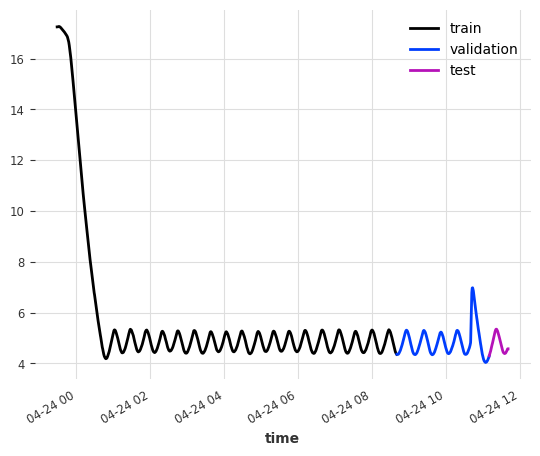

In [35]:
ts_train, ts_test = ts.split_after(pd.Timestamp('2023-04-24 8:40:00'))
ts_val, ts_test = ts_test.split_after(pd.Timestamp('2023-04-24 11:10:00'))
ts_train.plot(label='train')
ts_val.plot(label='validation')
ts_test.plot(label='test')


In [36]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import SeasonalityMode

model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)
model.fit(ts_train)
prediction = model.predict(len(ts_val), num_samples=5000)


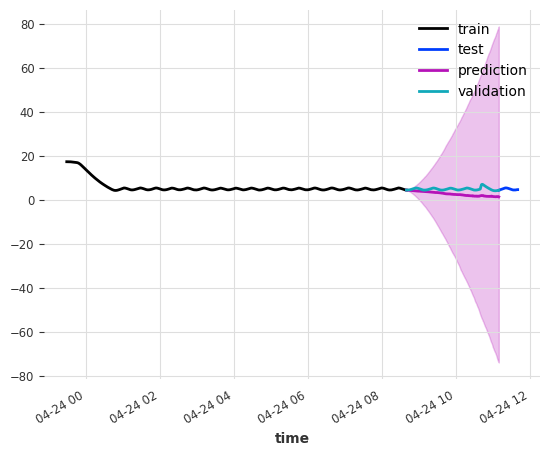

In [37]:
ts_train.plot(label='train')
ts_test.plot(label='test')
prediction.plot(label='prediction')
ts_val.plot(label='validation')